In [1]:
import sys
sys.path.append('/home/hlr/storage/egr/research-hlr/nafarali/DomiKnowS/regr')
sys.path.append('/home/hlr/storage/egr/research-hlr/nafarali/DomiKnowS/')

import torch
import numpy as np
from transformers import AdamW
from torch import nn
from regr.graph.relation import disjoint
from regr.program.loss import NBCrossEntropyLoss
from regr.program.metric import MacroAverageTracker, PRF1Tracker, MetricTracker, CMWithLogitsMetric
import logging
from regr.sensor.pytorch.learners import ModuleLearner
from regr.sensor.pytorch.sensors import ReaderSensor, JointSensor, FunctionalSensor, FunctionalReaderSensor
from regr.graph.logicalConstrain import nandL, ifL, V, orL, andL, existsL, notL, atLeastL, atMostL, eqL, xorL
from regr.graph import Graph, Concept, Relation
from WIQA_reader import make_reader
from regr.sensor.pytorch.relation_sensors import CompositionCandidateSensor
from regr.program import LearningBasedProgram
from regr.program.model.pytorch import model_helper, PoiModel
from WIQA_utils import RobertaTokenizer,is_ILP_consistant,test_inference_results
from WIQA_models import WIQA_Robert, RobertaClassificationHead,WIQAModel
import argparse
from WIQA_utils import make_pair, make_pair_with_labels, make_triple, make_triple_with_labels, guess_pair, guess_triple
from IPython.display import Image

from argparse import Namespace

args = Namespace(cuda_number=0,cur_epoch=1,learning_rate=2e-7,primaldual=False,samplenum=10,batch_size=13)

# here we set the cuda we want to use and the number of maximum epochs we want to train our model
cuda_number= args.cuda_number
cur_device = "cuda:"+str(cuda_number) if torch.cuda.is_available() else 'cpu'

current_model = WIQAModel if args.primaldual else PoiModel

# our reader is a list of dictionaries and each dictionary has the attributes for the root node to read
reader_train_aug = make_reader(file_address="data/WIQA_AUG/train.jsonl", sample_num=args.samplenum,batch_size=args.batch_size)
reader_dev_aug = make_reader(file_address="data/WIQA_AUG/dev.jsonl", sample_num=args.samplenum,batch_size=args.batch_size)
reader_test_aug = make_reader(file_address="data/WIQA_AUG/test.jsonl", sample_num=args.samplenum,batch_size=args.batch_size)
reader_dev = make_reader(file_address="data/WIQA/dev.jsonl", sample_num=args.samplenum,batch_size=args.batch_size)
reader_test = make_reader(file_address="data/WIQA/test.jsonl", sample_num=args.samplenum,batch_size=args.batch_size)

print("Graph Declaration:")
# reseting the graph
Graph.clear()
Concept.clear()
Relation.clear()

with Graph('WIQA_graph') as graph:
    #first we define paragrapg, then we define questions and add a constains relation from paragraph to question
    paragraph = Concept(name='paragraph')
    question = Concept(name='question')
    para_quest_contains, = paragraph.contains(question)

    # each question could be one the following three concepts:
    is_more = question(name='is_more')
    is_less = question(name='is_less')
    no_effect = question(name='no_effect')

    # we want only one of the labels to be true
    disjoint(is_more, is_less, no_effect)
    orL(is_more, is_less, no_effect)
    # the symmetric relation is between questions that are opposite of each other and have opposing values
    symmetric = Concept(name='symmetric')
    s_arg1, s_arg2 = symmetric.has_a(arg1=question, arg2=question)

    # here we define that if a question is is_more or is_less and it has a symmetric relation with another
    # question, then the second question should be is_less and is_more respectively
    ifL(is_more('x'), is_less('y', path=('x', symmetric.name, s_arg2.name)))
    ifL(is_less('x'), is_more('y', path=('x', symmetric.name, s_arg2.name)))

    # the transitive relation is between questions that have a transitive relation between them
    # meaning that the effect of the first question if the cause of the second question and the
    # third question si made of the cause of the first and the effect of the second question
    transitive = Concept(name='transitive')
    t_arg1, t_arg2, t_arg3 = transitive.has_a(arg11=question, arg22=question, arg33=question)


    # the transitive question impiles that if the first and the second question are is_more, so should be the
    # third question. but if the first question is is_more and the second question is is_less, then the third
    # question should also be is_less

    ifL(andL(is_more('x'), is_more('z', path=('x', transitive.name, t_arg2.name))),
        is_more('y', path=('x', transitive.name, t_arg3.name)))

    ifL(andL(is_more('x'), is_less('z', path=('x', transitive.name, t_arg2.name))),
        is_less('y', path=('x', transitive.name, t_arg3.name)))


* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


Log file for dataNode is in: /home/hlr/storage/egr/research-hlr/nafarali/DomiKnowS/examples/WIQA/datanode.log
Graph Declaration:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('arg1', 'question'), ('arg2', 'question')]) is used.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('arg11', 'question'), ('arg22', 'question'), ('arg33', 'question')]) is used.


the graph is depicted in the following picture

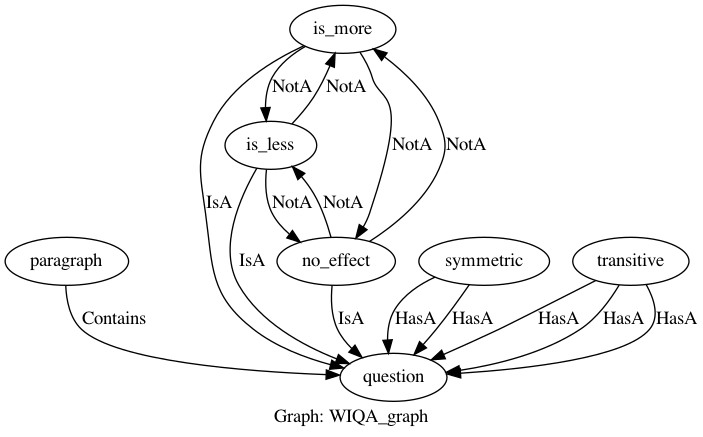

In [2]:
#graph.visualize("./image")
Image(filename='image.png')

the first sensor reads the text property of the paragraph

In [3]:
print("Sensor Part:")
paragraph['paragraph_intext'] = ReaderSensor(keyword='paragraph_intext')

Sensor Part:


the following sensors read the concatenated properties of the questions related to this paragraph
these concatenated properties will be splitted and put into their respective question later

In [4]:
paragraph['question_list'] = ReaderSensor(keyword='question_list')
paragraph['less_list'] = ReaderSensor(keyword='less_list')
paragraph['more_list'] = ReaderSensor(keyword='more_list')
paragraph['no_effect_list'] = ReaderSensor(keyword='no_effect_list')
paragraph['quest_ids'] = ReaderSensor(keyword='quest_ids')

the joint sensor here reads the concatenated question properties from the paragraph and put them into questions
the first property is the contain relation between paragraph and its questions
the output of the joint sensor is a tuple with 7 members. each member correspond to its respective property in question
for example the first element of the output tuple is a tensor of the shape (number of questions,1) meaning that each question
has a contain relation with the ith question.
the third element of the tuple is a list of str elements each a text of the a question related to the paragraph.

In [5]:
def str_to_int_list(x):
    return torch.LongTensor([[int(i)] for i in x])

def make_questions(paragraph, question_list, less_list, more_list, no_effect_list, quest_ids):
    return torch.ones((len(question_list.split("@@")), 1)), [paragraph for i in range(len(question_list.split("@@")))], \
           question_list.split("@@"), str_to_int_list(less_list.split("@@")), str_to_int_list(more_list.split("@@")), \
           str_to_int_list(no_effect_list.split("@@")), quest_ids.split("@@")

question[para_quest_contains, "question_paragraph", 'text', "is_more_", "is_less_", "no_effect_", "quest_id"] = JointSensor(
    paragraph['paragraph_intext'], paragraph['question_list'], paragraph['less_list'], paragraph['more_list'],
    paragraph['no_effect_list'], paragraph['quest_ids'],forward=make_questions)


we use another joint sensor, so given a roberta transformer tokenizer, we use the paragraph and question text, concat them and feed them
to the tokenizer and get the token_ids and masks for the <s>paragraph</s></s>question</s>

In [6]:
question["token_ids", "Mask"] = JointSensor(para_quest_contains, "question_paragraph", 'text',forward=RobertaTokenizer())

we load the is_more, is_less and no_effect attributes with label=True to tell the program
about the real label of these questions for training

In [7]:
def label_reader(_, label):
    return label

question[is_more] = FunctionalSensor(para_quest_contains, "is_more_", forward=label_reader, label=True)
question[is_less] = FunctionalSensor(para_quest_contains, "is_less_", forward=label_reader, label=True)
question[no_effect] = FunctionalSensor(para_quest_contains, "no_effect_", forward=label_reader, label=True)

roberta_model = WIQA_Robert()

we calculate the encoding for each <s>paragraph</s></s>question</s> by feeding it to roberta model
this is a ModuleLearner meaning that the parameters of roberta will be trained during learning

In [8]:
question["robert_emb"] = ModuleLearner("token_ids", "Mask", module=roberta_model)

the CompositionCandidateSensor takes two or three questions and return True or false if they are symmetric or transitive respectively

In [9]:
symmetric[s_arg1.reversed, s_arg2.reversed] = CompositionCandidateSensor(question['quest_id'],relations=(s_arg1.reversed, s_arg2.reversed),forward=guess_pair)
transitive[t_arg1.reversed, t_arg2.reversed, t_arg3.reversed] = CompositionCandidateSensor(question['quest_id'],relations=(t_arg1.reversed,t_arg2.reversed,t_arg3.reversed),forward=guess_triple)

finally the embedding are used to learn the label of each question by defining a linear model on top of roberta

In [10]:
question[is_more] = ModuleLearner("robert_emb", module=RobertaClassificationHead(roberta_model.last_layer_size))
question[is_less] = ModuleLearner("robert_emb", module=RobertaClassificationHead(roberta_model.last_layer_size))
question[no_effect] = ModuleLearner("robert_emb", module=RobertaClassificationHead(roberta_model.last_layer_size))

in our program we define POI ( points of interest) that are the final Concepts we want to be calculated
other inputs are graph, loss function and the metric

In [11]:
program = LearningBasedProgram(graph, model_helper(current_model,poi=[question[is_less], question[is_more], question[no_effect],\
                                    symmetric, transitive],loss=MacroAverageTracker(NBCrossEntropyLoss()), metric=PRF1Tracker()))

logging.basicConfig(level=logging.INFO)

at the end we run our program for each epoch and test the results each time

In [13]:
for i in range(args.cur_epoch):
    print("epoch: ",i)
    program.train(reader_train_aug, train_epoch_num=1, Optim=lambda param: AdamW(param, lr = args.learning_rate,eps = 1e-8 ), device=cur_device)
    print('-' * 40,"\n",'Training result:')
    print(program.model.loss)
    test_inference_results(program,reader_train_aug,cur_device,is_more,is_less,no_effect)
    test_inference_results(program,reader_dev_aug,cur_device,is_more,is_less,no_effect)
    test_inference_results(program,reader_test_aug,cur_device,is_more,is_less,no_effect)
    test_inference_results(program,reader_dev,cur_device,is_more,is_less,no_effect)
    test_inference_results(program,reader_test,cur_device,is_more,is_less,no_effect)

INFO:regr.program.program:Epoch: 0
INFO:regr.program.program:Training:
Epoch 0 Training:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:  0


Epoch 0 Training: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]
INFO:regr.program.program: - loss:
INFO:regr.program.program:{'is_less': tensor(0.6637), 'is_more': tensor(0.7105), 'no_effect': tensor(0.7003)}
INFO:regr.program.program: - metric:
INFO:regr.program.program: - - 
INFO:regr.program.program:{'is_less': {'P': tensor(0.3333, device='cuda:0'), 'R': tensor(0.5000, device='cuda:0'), 'F1': tensor(0.4000, device='cuda:0')}, 'is_more': {'P': tensor(0.2353, device='cuda:0'), 'R': tensor(0.8889, device='cuda:0'), 'F1': tensor(0.3721, device='cuda:0')}, 'no_effect': {'P': tensor(0.5517, device='cuda:0'), 'R': tensor(0.8000, device='cuda:0'), 'F1': tensor(0.6531, device='cuda:0')}}


---------------------------------------- 
 Training result:
{'is_less': tensor(0.6637), 'is_more': tensor(0.7105), 'no_effect': tensor(0.7003)}
accuracy: 0.5
ILP accuracy: 0.25
accuracy: 0.2727272727272727
ILP accuracy: 0.36363636363636365
accuracy: 0.2727272727272727
ILP accuracy: 0.18181818181818182
accuracy: 0.2727272727272727
ILP accuracy: 0.36363636363636365
accuracy: 0.2727272727272727
ILP accuracy: 0.18181818181818182
